Описание переменных:

    age: возраст в годах
    marital: семейное положение (женат, не женат)
    address: количество лет проживания по текущему адресу
    income: доход в тыс. у.е.
    ed: уровень образования
        - не законченное среднее образование
        - среднее образование
        - не законченное среднее специальное образование
        - среднее специальное образование
        - высшее образование
    employ: количество лет работы на текущей работе
    retire: получение пенсии (да, нет)
    gender: пол (мужской, женский)
    reside: количество человек в семье
    custcat: категория клиента (зависимая переменная)
        - Основные услуги
        - Электронные услуги
        - Расширенные услуги
        - Полный комплекс услуг




Задания
1) Постройте модель мультиномиальной логистической регрессии с
использованием указанных выше переменных.
2) Оцените значимость регрессионной модели.
3) Оцените точность модели. Какой процент наблюдений был отнесён моделью к верной категории? Рассмотрите процент верных предсказаний по группам, формируемым значениями зависимой переменной. Какая группа предсказана моделью лучше всего?
4) Интерпретируйте особенности взаимосвязей между зависимой переменной и независимыми переменными. Проанализируйте, как изменение значений независимых переменных влияет на шансы того, что респондент выберет тот или иной тип услуги, определяемый зависимой переменной.
5) Проанализируйте наблюдение номер 10 Какова вероятность выбора этим респондентом того или иного типа услуги? Какой выбор сделает этот респондент, согласно нашей модели и какой он сделал выбор на самом деле?

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc, classification_report
from statsmodels.miscmodels.ordinal_model import OrderedModel
import warnings
warnings.filterwarnings('ignore')   

In [5]:
df = pd.read_excel('C:/Users/daria/Downloads/telco.xls')
df.head(5) 

,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,44,женат,9,64,среднее специальное образование,5,нет,мужской,2,Основные услуги
1,33,женат,7,136,высшее образование,5,нет,мужской,6,Полный комплекс услуг
2,52,женат,24,116,не законченное среднее образование,29,нет,женский,2,Расширенные услуги
3,33,не женат,12,33,среднее образование,0,нет,женский,1,Основные услуги
4,30,женат,9,30,не законченное среднее образование,2,нет,мужской,4,Расширенные услуги


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   age      1000 non-null   int64 
 1   marital  1000 non-null   object
 2   address  1000 non-null   int64 
 3   income   1000 non-null   int64 
 4   ed       1000 non-null   object
 5   employ   1000 non-null   int64 
 6   retire   1000 non-null   object
 7   gender   1000 non-null   object
 8   reside   1000 non-null   int64 
 9   custcat  1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


Как мы видим, в нашем датасете нет пропущенных значений, что не требует дополнительной работы с ним.

In [7]:
# Названия переменных, сгруппированные по типам данных
for t in df.dtypes.unique():
     print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

Type: int64
['age' 'address' 'income' 'employ' 'reside']

Type: object
['marital' 'ed' 'retire' 'gender' 'custcat']



Соответственно, из переменных marital, ed, retire, gender нужно будет сделать dummie-переменные, а переменную custcat перевести в числовые значения, для удобства работы и для расчета корреляции

In [8]:
print(df['custcat'].value_counts())

custcat
Расширенные услуги       281
Основные услуги          266
Полный комплекс услуг    236
Электронные услуги       217
Name: count, dtype: int64


По полученному количеству значений мы видим, что группы являются наполненными, и такую переменную можно использовать в качестве зависимой переменной

In [9]:
pred = ['marital', 'ed', 'retire', 'gender']
for i in pred:
    print(df[i].value_counts())
    print("___________________")

marital
не женат    505
женат       495
Name: count, dtype: int64
___________________
ed
среднее образование                           287
среднее специальное образование               234
не законченное среднее специальное образов    209
не законченное среднее образование            204
высшее образование                             66
Name: count, dtype: int64
___________________
retire
нет    953
да      47
Name: count, dtype: int64
___________________
gender
женский    517
мужской    483
Name: count, dtype: int64
___________________


Как мы видим,практически все группы являются хорошо наполненными, за исключением "высшее образование" у переменной ed и "да" у переменной retire. В дальнейшем мы выберем их в качестве референтных, но нужно помнить, что из-за них модель может работать хуже.

Создадим дамми-переменные для marital, ed, retire, gender

In [10]:
# Возьмем в качестве референтной группы "не женат"
marital_dummies=pd.get_dummies(df['marital'], prefix='marital', prefix_sep='_', dtype=int)

# Возьмем в качестве референтной группы "высшее образование"
ed_dummies=pd.get_dummies(df['ed'], prefix='ed', prefix_sep='_', dtype=int)

# Возьмем в качестве референтной группы "да"
retire_dummies=pd.get_dummies(df['retire'], prefix='retire', prefix_sep='_', dtype=int)

# Возьмем в качестве референтной группы "женский"
gender_dummies=pd.get_dummies(df['gender'], prefix='gender', prefix_sep='_', dtype=int)

Добавим дамми-переменные в наш датасет

In [11]:
df = pd.concat([df, marital_dummies, ed_dummies, retire_dummies, gender_dummies], axis=1) 
df

,age,marital,address,income,ed,employ,retire,gender,reside,custcat,...,marital_не женат,ed_высшее образование,ed_не законченное среднее образование,ed_не законченное среднее специальное образов,ed_среднее образование,ed_среднее специальное образование,retire_да,retire_нет,gender_женский,gender_мужской
0,44,женат,9,64,среднее специальное образование,5,нет,мужской,2,Основные услуги,...,0,0,0,0,0,1,0,1,0,1
1,33,женат,7,136,высшее образование,5,нет,мужской,6,Полный комплекс услуг,...,0,1,0,0,0,0,0,1,0,1
2,52,женат,24,116,не законченное среднее образование,29,нет,женский,2,Расширенные услуги,...,0,0,1,0,0,0,0,1,1,0
3,33,не женат,12,33,среднее образование,0,нет,женский,1,Основные услуги,...,1,0,0,0,1,0,0,1,1,0
4,30,женат,9,30,не законченное среднее образование,2,нет,мужской,4,Расширенные услуги,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,39,не женат,0,27,не законченное среднее специальное образов,0,нет,женский,3,Основные услуги,...,1,0,0,1,0,0,0,1,1,0
996,34,не женат,2,22,высшее образование,5,нет,женский,1,Основные услуги,...,1,1,0,0,0,0,0,1,1,0
997,59,не женат,40,944,высшее образование,33,нет,женский,1,Полный комплекс услуг,...,1,1,0,0,0,0,0,1,1,0
998,49,не женат,18,87,среднее образование,22,нет,женский,1,Расширенные услуги,...,1,0,0,0,1,0,0,1,1,0


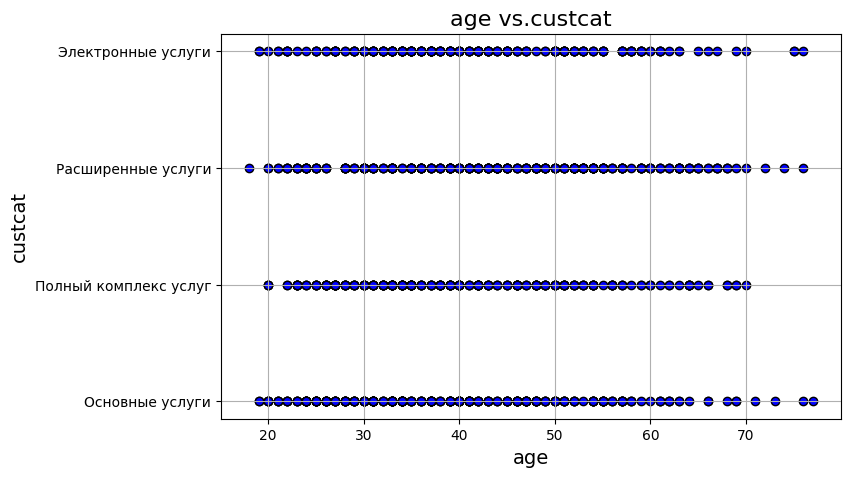

In [12]:
plt.figure(figsize=(8,5))
plt.title('age vs.custcat', fontsize=16)
plt.scatter(x=df["age"], y=df["custcat"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("age", fontsize=14)
plt.ylabel('custcat', fontsize=14)
plt.show()


### <b> Точечная диаграмма age-custcat показывает распределение возраста и категории клиента </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной age и custcat не наблюдается. Можно было предположить, что электронными услугами будут пользоваться люди в молодом возрасте, а расширенными услугами люди, в более зрелом возрасте, однако на графике четкой тенденции не видно.
#### Для каждой категории клиентов значения возраста распределены относительно равномерно.

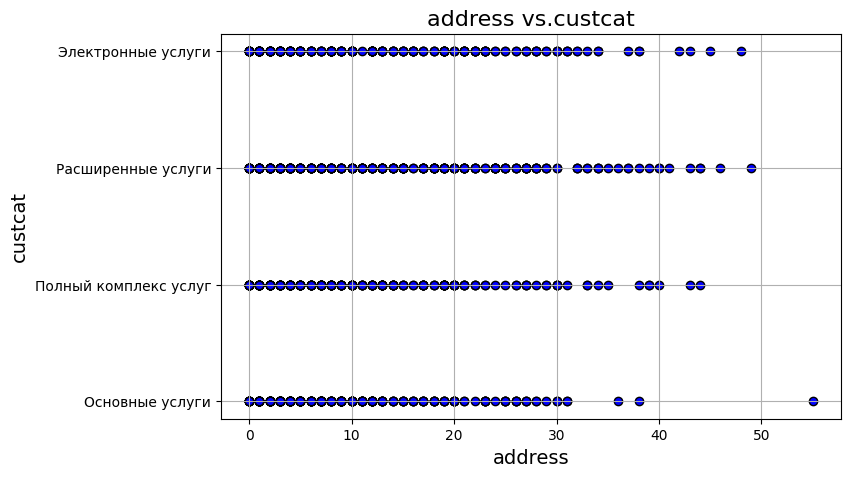

In [29]:
plt.figure(figsize=(8,5))
plt.title('address vs.custcat', fontsize=16)
plt.scatter(x=df["address"], y=df["custcat"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("address", fontsize=14)
plt.ylabel('custcat', fontsize=14)
plt.show()

### <b> Точечная диаграмма address-custcat показывает распределение количества лет проживания по текущему адресу и категории клиента </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной address и custcat не наблюдается. Можно было предположить, что люди, которые проживают по текущем адресу больше лет пользуются бОльшим перечнем услуг, однако на графике четкой тенденции не видно.
#### Для каждой категории клиентов значения количества лет проживания по текущему адресу распределены относительно равномерно.

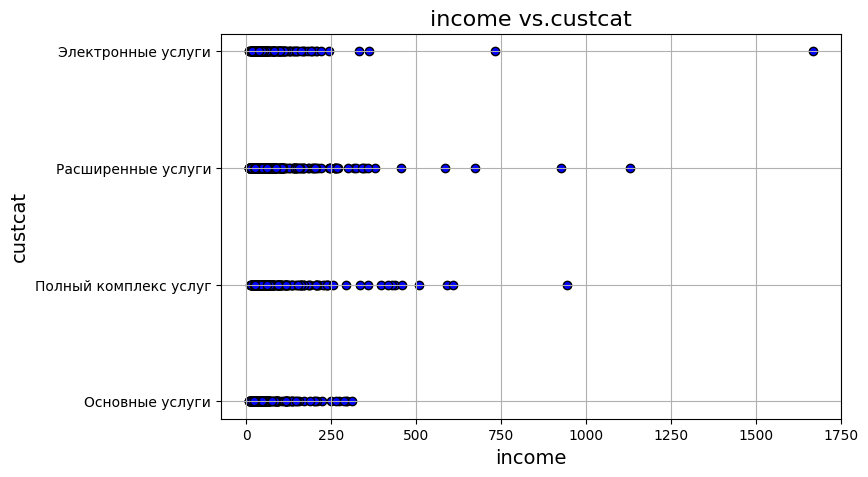

In [30]:
plt.figure(figsize=(8,5))
plt.title('income vs.custcat', fontsize=16)
plt.scatter(x=df["income"], y=df["custcat"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("income", fontsize=14)
plt.ylabel('custcat', fontsize=14)
plt.show()

### <b> Точечная диаграмма income-custcat показывает распределение дохода в тыс. у.е. и категории клиента </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной income и custcat не наблюдается. Можно было предположить, что люди с более высоким доходом используют более полные пакеты услуг, однако на графике четкой тенденции не видно.
#### Для каждой категории клиентов значения дохода в тыс. у.е. распределены относительно равномерно.
#### Стоит отметить, что в каждой категории присутствуют клиенты с более высокими доходами, но их численность уменьшается по мере увеличения дохода. Каждая категория охватывает широкий диапазон доходов, что указывает на то, что доход не является единственным определяющим фактором для выбора услуги.

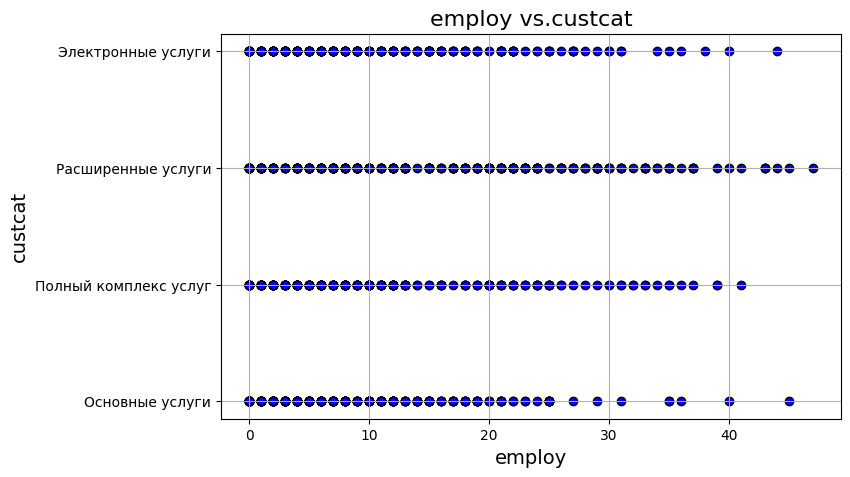

In [25]:
plt.figure(figsize=(8,5))
plt.title('employ vs.custcat', fontsize=16)
plt.scatter(x=df["employ"], y=df["custcat"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("employ", fontsize=14)
plt.ylabel('custcat', fontsize=14)
plt.show()

### <b> Точечная диаграмма employ-custcat показывает распределение количества лет работы на текущей работе и категории клиента </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной employ и custcat не наблюдается. Можно было предположить, что чем дольше человек работает на текущей работе, тем более расширенным перечнем услуг он будет пользоваться, однако на графике четкой тенденции не видно.
#### Для каждой категории клиентов значения количества лет работы на текущей работе распределены относительно равномерно.

<Axes: xlabel='custcat'>

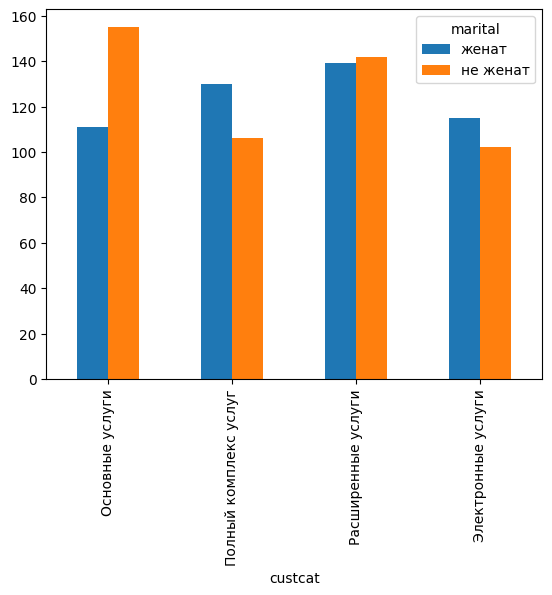

In [28]:
ct = pd.crosstab(df["custcat"], df["marital"])
ct.plot.bar()

### <b> Столбиковая диаграмма marital-custcat показывает распределение категории клиента среди состоящих и не состоящих в браке</b>
#### На данной диаграмме мы видим, что в каждой группе есть представленность из каждого класса, а значит переменную marital можно добавить в качестве предиктора (Если бы у нас были значения только бы из одного класса, тогда не было бы смысла выбираеть ее предиктором, так как модель однозначно определяла бы результат по этому классу). 
#### По данной диаграмме можно отметить следующее: 
#### 1) Большая доля клиентов, выбирающих "Основные услуги", не состоит в браке.
#### 2) Среди клиентов, выбирающих "Полный комплекс услуг", больше людей, которые состоят в браке.
#### 3) Среди клиентов, выбирающих "Расширенные услуги" количество женатых и не женатых клиентов почти одинаковое, но не женатых чуть больше.
#### 4) Среди клиентов, выбирающих "Электронные услуги" женатые клиенты преобладают над неженатыми.
#### Можно предположить, что переменная marital имеет потенциальное влияние на категорию клиента, так как видны различия в распределении семейного статуса между категориями услуг.

<Axes: xlabel='custcat'>

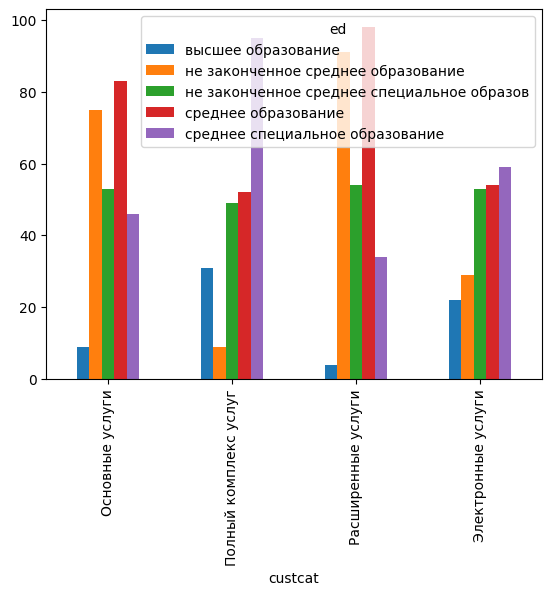

In [31]:
ct = pd.crosstab(df["custcat"], df["ed"])
ct.plot.bar()

### <b> Столбиковая диаграмма ed-custcat показывает распределение категории клиента среди людей, имеющих определенную степень образования</b>
#### На данной диаграмме мы видим, что в каждой группе есть представленность из каждого класса, а значит переменную ed можно добавить в качестве предиктора (Если бы у нас были значения только бы из одного класса, тогда не было бы смысла выбираеть ее предиктором, так как модель однозначно определяла бы результат по этому классу). 
#### По данной диаграмме можно отметить следующее: 
#### 1) Среди клиентов, выбирающих "Основные услуги" основную долю клиентов составляют те, кто имеет среднее образование или не законченное среднее образование. Незначительное число клиентов с высшим образованием.
#### 2) Среди клиентов, выбирающих "Полный комплекс услуг", чаще всего встречаются клиенты со средним специальным образованием. Меньше всего клиентов с незаконченным средним образованием.
#### 3) Среди клиентов, выбирающих "Расширенные услуги" больше всего клиентов с средним образованием или не законченным средним образованием, а меньше всего людей с высшим образованием.
#### 4) Среди клиентов, выбирающих "Электронные услуги" больше всего клиентов, имеющих среднее специально образование, а меньше всего представителей с высшим образованием, однако люди, имеющие другие ступени образования также встречаются в данной категории довольно-таки часто.
#### В итоге можно отметить, что переменная ed является значимым предиктором, так как видны различия в распределении категорий услуг в зависимости от уровня образования.


<Axes: xlabel='custcat'>

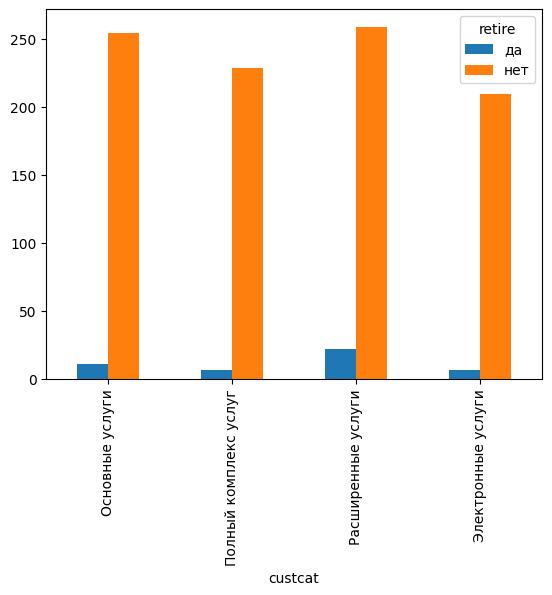

In [32]:
ct = pd.crosstab(df["custcat"], df["retire"])
ct.plot.bar()

### <b> Столбиковая диаграмма retire-custcat показывает распределение категории клиента среди людей, получающих и не получающих пенсию</b>
#### На данной диаграмме мы видим, что в каждой группе есть представленность из каждого класса, а значит переменную retire можно добавить в качестве предиктора (Если бы у нас были значения только бы из одного класса, тогда не было бы смысла выбираеть ее предиктором, так как модель однозначно определяла бы результат по этому классу). 
#### По данной диаграмме сразу можно отметить явные особенности, большинство клиентов не получает пенсию (оранжевые столбцы значительно превышают синие) и клиенты, получающие пенсию, составляют лишь небольшую долю в каждой категории.
#### В итоге, переменная retire может быть менее информативной для классификации клиентов, так как доля пенсионеров в выборке слишком мала и основное влияние на категорию клиента оказывают клиенты, не получающие пенсию.


<Axes: xlabel='custcat'>

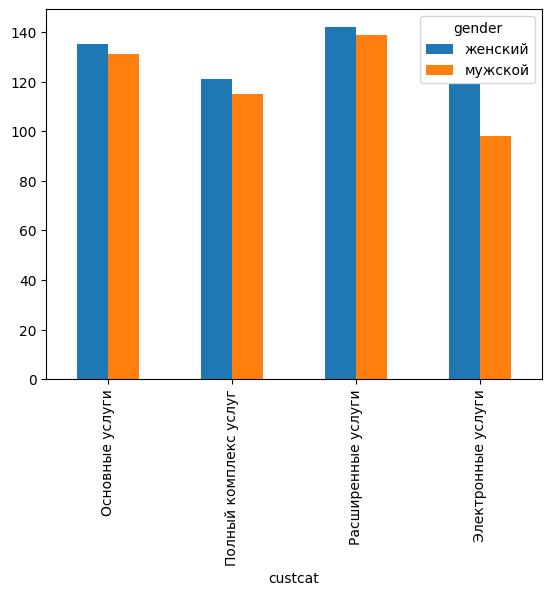

In [33]:
ct = pd.crosstab(df["custcat"], df["gender"])
ct.plot.bar()

### <b> Столбиковая диаграмма gender-custcat показывает распределение категории клиента среди женщин и мужчин</b>
#### На данной диаграмме мы видим, что в каждой группе есть представленность из каждого класса, а значит переменную gender можно добавить в качестве предиктора (Если бы у нас были значения только бы из одного класса, тогда не было бы смысла выбираеть ее предиктором, так как модель однозначно определяла бы результат по этому классу). 
#### По данной диаграмме сложно отметить явные особенности, так как соотношение количества мужчин и женщин во всех категориях услуг примерно одинаковое - в принципе, всеми кактегориями услуг женщины пользуются чаще, чем мужчины. Среди Всех услуг сильно выбиваются "Электронные услуги", по которым видно, что женщины их используют значительно чаще. чем мужчины.
#### Можно предположить, что переменная gender имеет слабое влияние на категорию клиента, так как значительных отличий в распределении не наблюдается.

<Axes: xlabel='custcat'>

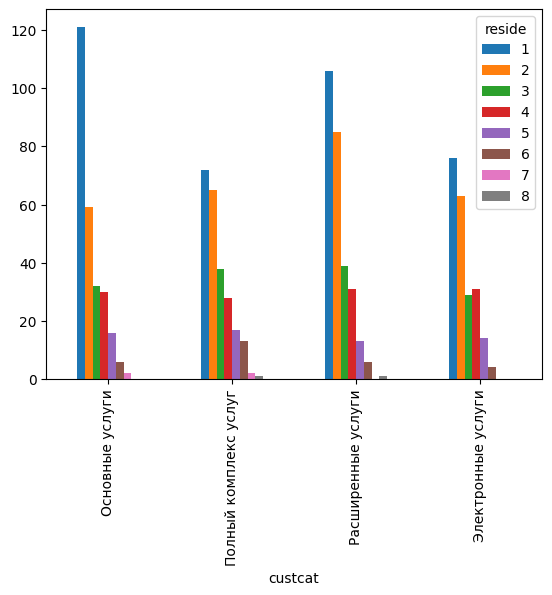

In [45]:
ct = pd.crosstab(df["custcat"], df["reside"])
ct.plot.bar()

### <b> Столбиковая диаграмма reside-custcat показывает распределение категории клиента среди людей, имеющих определенное количество человек в семье</b>
#### На данной диаграмме мы видим, что в каждой группе есть представленность из каждого класса, а значит переменную reside можно добавить в качестве предиктора (Если бы у нас были значения только бы из одного класса, тогда не было бы смысла выбираеть ее предиктором, так как модель однозначно определяла бы результат по этому классу). 
#### По данной диаграмме можно отметить, что среди всех категорий клиентов наблюдается примерно одна и та же картина: Чем меньше людей в семье, тем меньше представителей данной категории в каждом классе.
#### В итоге можно отметить, что переменная reside может быть использована в качестве предиктора, так как различные значения встречаются в различных классах.


In [14]:
custcat_dict = {
    'Основные услуги' : 1,
    'Полный комплекс услуг' : 2,
    'Расширенные услуги' : 3,
    'Электронные услуги' : 4
}
df_model = df.copy()
df_model['custcat_nums'] = df_model['custcat'].map(custcat_dict)

Перекодируем нашу таргетную переменную в числовые значения (для того, чтобы посмотреть корреляцию и в дальнейшем будем работать с этой "меткой класса")

<Axes: >

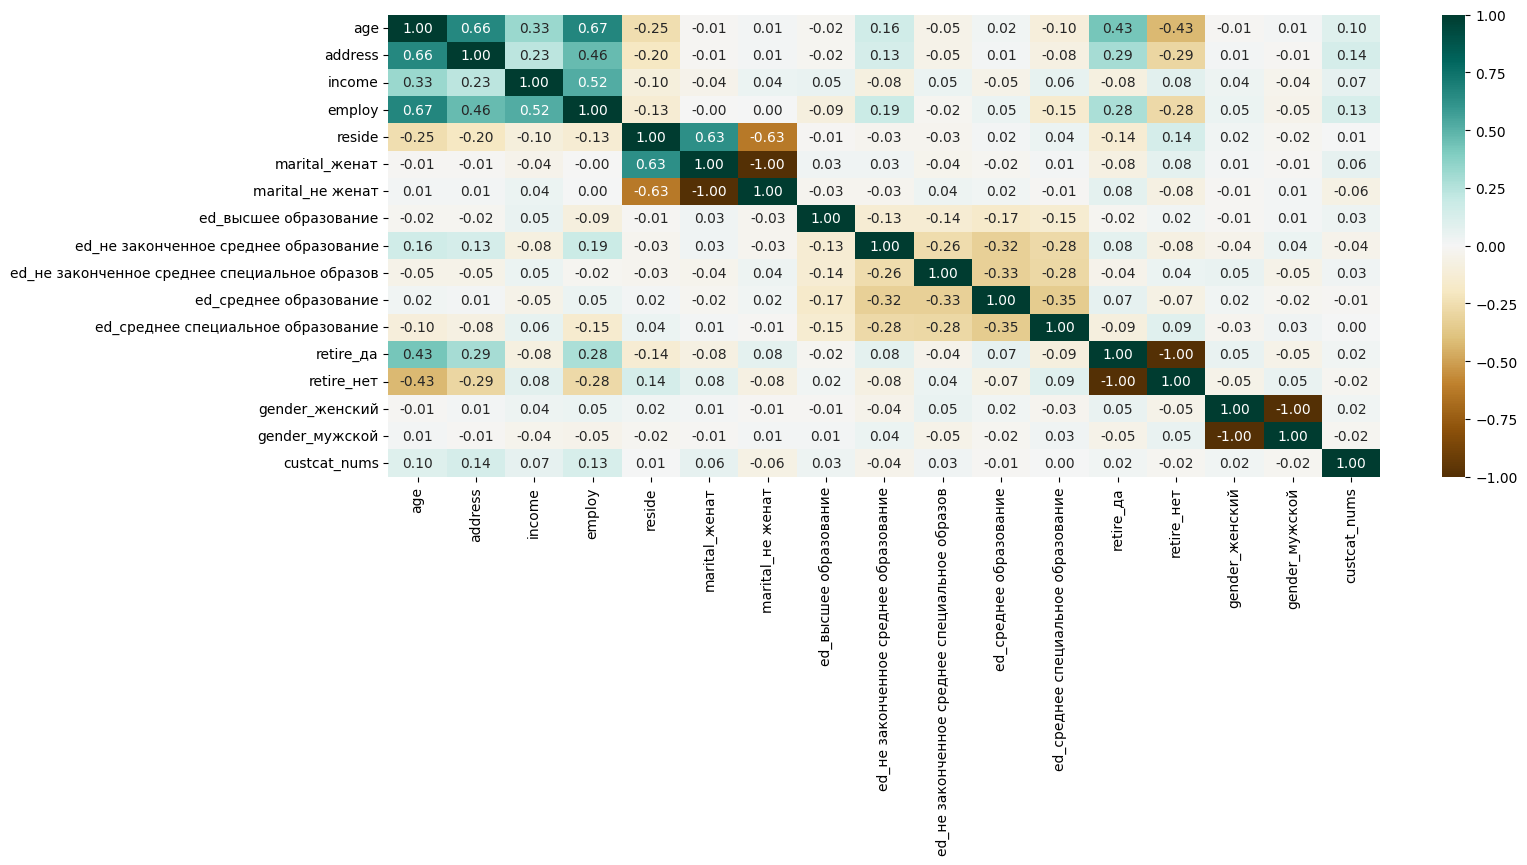

In [15]:
import seaborn as sns

corr_matrix = df_model.corr(numeric_only=True)
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, cmap='BrBG', annot=True,fmt=".2f")

Как мы видим, в нашем датасете нет переменных, сильно коррелирующих между собой (выше 0,75), а также с таргетной переменной. Соответсвенно, построенная в дальнейшем модель будет выдавать результаты на реально найденных зависимостях, а не опираться на предиктор с наибольшим влиянием.

In [16]:
x_mult = df_model[[ "age", "address", "income", "employ", "reside", #метрические
    "marital_женат", # бинарная, референт "не женат"
    "ed_не законченное среднее образование", "ed_не законченное среднее специальное образов", "ed_среднее образование", "ed_среднее специальное образование", # категориальная, референт "высшее"
    "retire_нет",  # бинарная, референт "да"
    "gender_мужской"]]  # бинарная, референт "женский"
y = df_model["custcat_nums"]
x_mult_constant = sm.add_constant(x_mult)

In [17]:
model = sm.MNLogit(y, x_mult_constant).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 1.253541
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:           custcat_nums   No. Observations:                 1000
Model:                        MNLogit   Df Residuals:                      961
Method:                           MLE   Df Model:                           36
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                 0.09247
Time:                        22:33:57   Log-Likelihood:                -1253.5
converged:                       True   LL-Null:                       -1381.3
Covariance Type:            nonrobust   LLR p-value:                 7.028e-35
                               custcat_nums=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                 

### <b> Рассмотрим основные метрики полученной модели: </b>

#### В качестве референтной группы автоматически была взята категория клиентов, которые пользуются основными услугами.

#### Псевдо R-квадрат (0,09247) указывает, что модель объясняет около 9.2% вариации зависимой переменной. Это довольно-таки низкое значение, однако, для панельных данных в принципе сложно достигнуть высоких значений.

#### Логарифм правдоподобия для модели без предикторов (-1381,3). Это правдоподобие "нулевой" модели, в которой нет предикторов, только константа.

#### Сравнив LL и LL-Null можно сказать, что добавление предикторов значительно улучшает модель по сравнению с нулевой моделью.

#### P-value (7,028e-35) указывает на статистическую значимость модели . Такое низкое значение говорит о том, что модель значимо лучше, чем нулевая модель, и предикторы действительно влияют на категорию клиента. По данному значению можно сказать, что модель статистически значима.

In [18]:
#добавим коэффициенты регрессии
coefs = model.params
coefs.columns = ['1_VS_2', '1_VS_3', '1_VS_4']
#добавим отношения шансов
coefs['OddsRatio_1_VS_2'] = np.exp(coefs["1_VS_2"])
coefs['OddsRatio_1_VS_3'] = np.exp(coefs["1_VS_3"])
coefs['OddsRatio_1_VS_4'] = np.exp(coefs["1_VS_4"])
coefs

,1_VS_2,1_VS_3,1_VS_4,OddsRatio_1_VS_2,OddsRatio_1_VS_3,OddsRatio_1_VS_4
const,0.569705,-0.872043,0.015526,1.767746,0.418097,1.015647
age,-0.014389,-0.015379,-0.013034,0.985714,0.984739,0.987051
address,0.028563,0.027343,0.044383,1.028975,1.027720,1.045383
income,0.001903,0.002198,0.000076,1.001905,1.002201,1.000076
employ,0.040768,0.047682,0.036202,1.041610,1.048837,1.036866
reside,0.178984,-0.006512,0.027022,1.196002,0.993509,1.027391
marital_женат,0.280799,0.353968,0.434605,1.324187,1.424709,1.544353
ed_не законченное среднее образование,-3.652502,0.695449,-2.195164,0.025926,2.004609,0.111340
ed_не законченное среднее специальное образов,-1.412612,0.738638,-0.990168,0.243506,2.093083,0.371514
ed_среднее образование,-1.868406,0.833405,-1.498570,0.154370,2.301140,0.223450


### <b> Рассмотрим коэффициенты модели, к которым применена функция экспоненты, и их значимость для интерпретации отнесения клиента к конкретной категории, с учетом 5% значимости: </b>

#### <b> При сравнении клиентов, относящихся к категориям "Основные услуги" и "Полный комплекс услуг" можно отметить следующее: </b>

##### Предикторы age, income, marital, ed_среднее специальное образование, retire и gender не являются статистически значимыми - нет необходимости их интерпритировать. 

##### <b> Address. </b> С увеличением количества лет проживания на одном месте на 1 год, в среднем, снижаются шансы быть клиентом, использующим "Полный комплекс услуг" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 1,4%;
##### <b> Employ. </b> С увеличением количества количество лет работы на текущей работе на 1 у.е., в среднем, увеличиваются шансы быть клиентом, использующим "Полный комплекс услуг" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 4,1%;
##### <b> Reside. </b> С увеличением количества человек в семье на 1 человека, в среднем, увеличиваются шансы быть клиентом, использующим "Полный комплекс услуг" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 19,6%;
##### <b> Ed_не законченное среднее образование. </b> В среднем, у человека, имеющего не законченное среднее образование, по сравнению с человеком, имеющим высшее образование, снижаются шансы быть клиентом, использующим "Полный комплекс услуг" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 97,4%;
##### <b> Ed_не законченное среднее специальное образование. </b> В среднем, у человека, имеющего не законченное среднее специальное образование, по сравнению с человеком, имеющим высшее образование, снижаются шансы быть клиентом, использующим "Полный комплекс услуг" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 75,7%;
##### <b> Ed_среднее образование. </b> В среднем, у человека, имеющего среднее образование, по сравнению с человеком, имеющим высшее образование, снижаются шансы быть клиентом, использующим "Полный комплекс услуг" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 84,6%.


#### <b> При сравнении клиентов, относящихся к категориям "Основные услуги" и "Расширенные услуги" можно отметить следующее: </b>

##### Предикторы age, income, reside, marital, ed, retire и gender не являются статистически значимыми - нет необходимости их интерпритировать. 

##### <b> Address. </b> С увеличением количества лет проживания на одном месте на 1 год, в среднем, снижаются шансы быть клиентом, использующим "Расширенные услуги" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 1,5% 
##### <b> Employ. </b> С увеличением количества количества лет работы на текущей работе на 1 у.е., в среднем, увеличиваются шансы быть клиентом, использующим "Расширенные услуги" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 4,9%;



#### <b> При сравнении клиентов, относящихся к категориям "Основные услуги" и "Электронные услуги" можно отметить следующее: </b>

##### Предикторы age, income, reside, marital, ed_среднее специальное образование, retire и gender не являются статистически значимыми - нет необходимости их интерпритировать. 

##### <b> Address. </b> С увеличением количества лет проживания на одном месте на 1 год, в среднем, снижаются шансы быть клиентом, использующим "Электронные услуги" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 1,3% 
##### <b> Employ. </b> С увеличением количества количества лет работы на текущей работе на 1 у.е., в среднем, увеличиваются шансы быть клиентом, использующим "Расширенные услуги" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 3,7%;
##### <b> Ed_не законченное среднее образование. </b> В среднем, у человека, имеющего не законченное среднее образование, по сравнению с человеком, имеющим высшее образование, снижаются шансы быть клиентом, использующим "Электронные услуги" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 88,9%;
##### <b> Ed_не законченное среднее специальное образование. </b> В среднем, у человека, имеющего не законченное среднее специальное образование, по сравнению с человеком, имеющим высшее образование, снижаются шансы быть клиентом, использующим "Электронные услуги" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 62,9%;
##### <b> Ed_среднее образование. </b> В среднем, у человека, имеющего среднее образование, по сравнению с человеком, имеющим высшее образование, снижаются шансы быть клиентом, использующим "Электронные услуги" по сравнению с шансом быть клиентом, использующим "Основные услуги" примерно на 77,7%.

### Матрица ошибок

In [20]:
cm = model.pred_table()
pd.DataFrame(cm, index=['1-st','2-nd', '3-rd', '4-rd'],
columns=['predicted_1-st', 'predicted_2-nd', 'predicted_3-rd',  'predicted_4-rd'])

,predicted_1-st,predicted_2-nd,predicted_3-rd,predicted_4-rd
1-st,124.0,56.0,76.0,10.0
2-nd,50.0,131.0,39.0,16.0
3-rd,86.0,48.0,132.0,15.0
4-rd,52.0,77.0,67.0,21.0


### Из полученной матрицы ошибок можно сделать следующий вывод:

#### 1) Основные услуги: 124 значения предсказано верно, ошибочно предсказано 142 значения (56 как полный комплекс услуг, 76 как расширенные услуги и 10 как электронные услуги).
##### <b> Recall </b> (Процент верных предсказаний) = 124/(124+142)*100 = 46,62% 

#### 2) Полный комплекс услуг: 131 значение предсказано верно, ошибочно классифицировано 105 значений (50 как основные услуги, 39 как расширенные услуги, и 16 как электронные услуги).
##### <b> Recall </b> (Процент верных предсказаний) = 131/(131+105)*100 = 55,51% 

#### 3) Расширенные услуги: 132 значения предсказано верно, ошибочно классифицировано 149 значения (86 как основные услуги, 48 как полный комплекс услуг и 15 как электронные услуги).
##### <b> Recall </b> (Процент верных предсказаний) = 132/(132+149)*100 = 46,98% 

#### 4) Электронные услуги: 21 значение предсказано верно, ошибочно классифицировано 196 значений (52 как основные услуги, 77 как полный комплек услуги и 67 как расширенные услуги)
##### <b> Recall </b> (Процент верных предсказаний) = 21/(21+196)*100 = 9,68% 

#### Как мы видим, основные услуги, полные комплекс услуг и расширенные услуги классифицируются довольно-таки неплохо, а вот электронные услуги имеют значительно меньшее количество верных предсказаний (21), что указывает на проблему с классификацией этой категории, хотя, в выборке по всем категориям примерно одинаковое количество значений. Это означет, что модель не смогла выявить зависимостей, влиющих на выбор электронных услуг.
##### По полученным значениям recall (процента верных предсказаний), можно отметить, что лучшая предсказанная группа — 2 (Полный комплекс услуг) с точностью 55,51%, а худшая предсказанная группа — 4 (Электронные услуги) с точностью 9,68%. Группы 1 (Основные услуги) и 3 (Расширенные услуги) имеют схожую точность, около 46-47%.

In [23]:
accuracy = np.diag(cm).sum()/cm.sum()
print('Точность (процент верно предсказанных событий): {}'.format(accuracy))

Точность (процент верно предсказанных событий): 0.408


#### По полученному значению accuracy можно сказать, что модель правильно предсказывает только около 40,8% событий, что является довольно-таки низким значенем и указывает на наличие большого количество ошибок при классификации. Возможной причиной такого результата является недостаточность признаков, то есть используемые предикторы могут не нести достаточно информации для точного определения категории клиента.

### <b> Мультиколлинеарность </b>

In [36]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

In [38]:
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
11,1.016188,gender_мужской
10,1.359374,retire_нет
2,1.618188,income
5,1.733532,marital_женат
1,1.786536,address
4,1.846345,reside
3,2.441520,employ
0,2.914116,age
7,3.356528,ed_не законченное среднее специальное образов
6,3.492265,ed_не законченное среднее образование


### <b> Итоговый датасет </b>


Нет значений VIF, превышающих 10. Проблема мультиколлинеарности отсутствует.

In [39]:
predicted = pd.DataFrame(model.predict())
predicted.columns = ['1', '2', '3', '4']  #добавляем вероятности каждого класса для каждого наблюдения
predicted['predicted_group'] = predicted.idxmax(axis=1)  #добавляем метки категорий для каждого наблюдения в выборке (по номеру колонки)

res = pd.concat([df_model, predicted], axis=1)
res #склеиваем полученные метки категорий с исходными данными

,age,marital,address,income,ed,employ,retire,gender,reside,custcat,...,retire_да,retire_нет,gender_женский,gender_мужской,custcat_nums,1,2,3,4,predicted_group
0,44,женат,9,64,среднее специальное образование,5,нет,мужской,2,Основные услуги,...,0,1,0,1,1,0.205233,0.379656,0.150444,0.264666,2
1,33,женат,7,136,высшее образование,5,нет,мужской,6,Полный комплекс услуг,...,0,1,0,1,2,0.077035,0.648285,0.043584,0.231095,2
2,52,женат,24,116,не законченное среднее образование,29,нет,женский,2,Расширенные услуги,...,0,1,1,0,3,0.155827,0.050824,0.585705,0.207644,3
3,33,не женат,12,33,среднее образование,0,нет,женский,1,Основные услуги,...,0,1,1,0,1,0.424623,0.127170,0.261025,0.187182,1
4,30,женат,9,30,не законченное среднее образование,2,нет,мужской,4,Расширенные услуги,...,0,1,0,1,3,0.432066,0.052689,0.376991,0.138254,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,39,не женат,0,27,не законченное среднее специальное образов,0,нет,женский,3,Основные услуги,...,0,1,1,0,1,0.451967,0.196603,0.161686,0.189744,1
996,34,не женат,2,22,высшее образование,5,нет,женский,1,Основные услуги,...,0,1,1,0,1,0.223736,0.386095,0.055473,0.334696,2
997,59,не женат,40,944,высшее образование,33,нет,женский,1,Полный комплекс услуг,...,0,1,1,0,2,0.010355,0.668541,0.142516,0.178589,2
998,49,не женат,18,87,среднее образование,22,нет,женский,1,Расширенные услуги,...,0,1,1,0,3,0.216084,0.165806,0.393385,0.224726,3


##### Последнее задание звучало так: "Проанализируйте наблюдение номер 10 Какова вероятность выбора этим респондентом того или иного типа услуги? Какой выбор сделает этот респондент, согласно нашей модели и какой он сделал выбор на самом деле?"

In [40]:
res.iloc[10] 
#Берем наблюдение номер 10, учитывая, что нумерация в датафрейме начинается с нуля, то, получается, что это 11 по порядку наблюдение.

age                                                                           33
marital                                                                 не женат
address                                                                       10
income                                                                       125
ed                                               среднее специальное образование
employ                                                                         5
retire                                                                       нет
gender                                                                   женский
reside                                                                         1
custcat                                                          Основные услуги
marital_женат                                                                  0
marital_не женат                                                               1
ed_высшее образование       

#### Исходя из полученных данным, респондент под номером 10:
    - с вероятностью 23% мог относиться к категории 1 "Основные услуги";
    - с вероятностью 36% мог относиться к категории 2 "Полный комплекс услуг";
    - с вероятностью 15% мог относиться к категории 3 "Расширенные услуги";
    - с вероятностью 26% мог относиться к категории 4  "Электронные услуги".
#### Согласно исходных данных респондет относится к клиенту, использующему "Основные услуги" (1 категория), однако, по данным построенной модели он бы стал клиентом, использующим "Полный комплекс услуг" (так как вероятность 36% выше, чем все остальные вероятности в данном случае).